# Benchmark

## Read the data

In [2]:
import os
import pandas as pd


sapsDf = pd.read_csv(os.environ['EICU_EHR_PIPELINE_BASE'] + '/data/saps_ii/saps_ii.csv')
ehrmlAllDf = pd.read_csv(os.environ['EICU_EHR_PIPELINE_BASE'] + '/data/saps_ii/preds.csv')
ehrmlSapsDf = pd.read_csv(os.environ['EICU_EHR_PIPELINE_BASE'] + '/data/saps_ii/sapsii_preds.csv')
datamatrixDf = pd.read_csv(os.environ['EICU_EHR_PIPELINE_BASE'] + '/data/final/data_matrix.csv')
sapsDf.shape, ehrmlAllDf.shape, ehrmlSapsDf.shape

((9012, 4), (2216, 3), (1784, 3))

## Combine the data

In [3]:
combinedDf = datamatrixDf[['person_id', 'visit_occurrence_id', 'death_adm']]\
    .merge(sapsDf, how='inner', on=['person_id', 'visit_occurrence_id'])\
        .merge(ehrmlAllDf.add_suffix('_all'), how='inner', left_on=['person_id', 'visit_occurrence_id'], right_on=['person_id_all', 'visit_occurrence_id_all'])\
            .drop(columns=['person_id_all', 'visit_occurrence_id_all'])\
                .merge(ehrmlSapsDf.add_suffix('_saps'), how='left', left_on=['person_id', 'visit_occurrence_id'], right_on=['person_id_saps', 'visit_occurrence_id_saps'])\
                    .drop(columns=['person_id_saps', 'visit_occurrence_id_saps'])\
                        .drop_duplicates()
                # .sample(n=1000)
combinedDf

,person_id,visit_occurrence_id,death_adm,saps_ii,saps_ii_pred,preds_all,preds_saps
0,248364,141515,0,49,0.437547,0.055872,0.012025
7,238079,142483,0,47,0.391926,0.000161,0.034829
37,22143,146788,0,23,0.052195,0.001853,0.000667
38,210052,151900,0,21,0.041754,0.004518,0.002713
41,26227,155503,0,60,0.680887,0.021447,NaN
...,...,...,...,...,...,...,...
8906,3511532,3348836,0,40,0.247443,0.017030,NaN
8910,3519950,3351084,0,23,0.052195,0.000006,NaN
8911,355785,3351708,1,63,0.736299,0.006140,NaN
8914,351704,3352358,0,51,0.483852,0.002894,NaN


In [4]:
combinedSapsDf = datamatrixDf[['person_id', 'visit_occurrence_id', 'death_adm']]\
    .merge(ehrmlSapsDf, how='inner', on=['person_id', 'visit_occurrence_id'])\
        .drop_duplicates()
combinedSapsDf

,person_id,visit_occurrence_id,death_adm,preds
0,248364,141515,0,0.012025
7,238079,142483,0,0.034829
37,22143,146788,0,0.000667
38,210052,151900,0,0.002713
41,265493,153170,0,0.000165
...,...,...,...,...
9191,3517736,3352103,0,0.000407
9195,3517736,3352104,0,0.000750
9196,3516377,3352271,0,0.002510
9198,355375,3352633,0,0.013836


## Plot

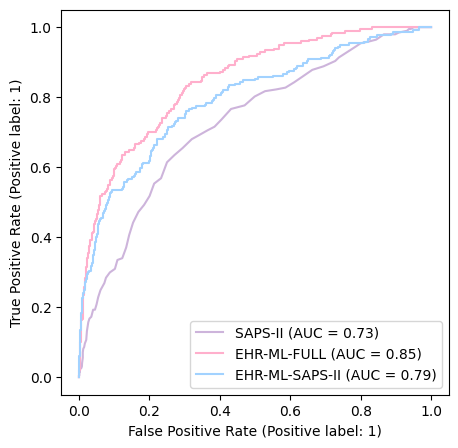

In [5]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from matplotlib import pyplot as plt


fig, ax = plt.subplots(figsize=(5, 5))

fpr, tpr, _  = roc_curve(combinedDf.death_adm, combinedDf.saps_ii_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay.from_predictions(combinedDf.death_adm, combinedDf.saps_ii_pred, name='SAPS-II', ax=ax, color='#cdb4db')

fpr, tpr, _  = roc_curve(combinedDf.death_adm, combinedDf.preds_all)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay.from_predictions(combinedDf.death_adm, combinedDf.preds_all, name='EHR-ML-FULL', ax=ax, color='#ffafcc')

fpr, tpr, _  = roc_curve(combinedSapsDf.death_adm, combinedSapsDf.preds)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay.from_predictions(combinedSapsDf.death_adm, combinedSapsDf.preds, name='EHR-ML-SAPS-II', ax=ax, color='#a2d2ff')

plt.show()